In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import tensorflow as tf
import sys, os

from gf321_utils import bvh_utils
from gf321_utils import marker_utils
from gf321_utils import plot_utils
import neural_lbs

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.3.0
Eager execution: True


In [3]:
#Make neural lbs class
nn = neural_lbs.Neural_LBS()

#Load the data
nn.load_tr_data()

print(nn.marker_data.shape)
print(nn.joint_data.shape)

(5252, 192)
(5252, 43, 3, 4)


In [4]:
#Compile model
nn.compile()

In [5]:
#Train model, using test data as validation for now
#nn.train(1) to observe epoch by epoch progress
nn.train()

Training...
132/132 [==============================] - 0s 939us/step - loss: 0.0073
Training loss:  0.0072581712156534195
33/33 [==============================] - 0s 962us/step - loss: 0.0102
Validation loss:  0.010150577872991562


In [6]:
#Import evaluation testSeq data
bvh = bvh_utils.BVHData()
bvh.bvhRead('neural_lbs_data/dog1_testSeq_skeleton.bvh')
joints_testseq = bvh.getJointAngles()
markers_testseq = marker_utils.read_markers('neural_lbs_data/dog1_testSeq_markers.json')
markers_testseq =np.delete(markers_testseq,-1,0) # Delete last frame to align with joint data

Reading BVH File.. neural_lbs_data/dog1_testSeq_skeleton.bvh
Done
Reading JSON File.. neural_lbs_data/dog1_testSeq_markers.json
Done


In [7]:
#Make local

joints_local = bvh_utils.make_joints_local(joints_testseq)
local_tfs = bvh_utils.create_local_tfs_root(joints_testseq)
markers_local = marker_utils.make_markers_local(markers_testseq,local_tfs)

#Predict
marker_preds = nn.predict(joints_local)

#Test
nn.eval(joints_testseq, markers_testseq)

#Make global
global_tfs = np.zeros((joints_testseq.shape[0],4,4))
global_tfs[:,:3] = joints_testseq[:,0]
global_tfs[:,3,3] = 1

marker_preds_4 = np.zeros((marker_preds.shape[0],marker_preds.shape[1],4))
marker_preds_4[:,:,:3] = marker_preds[:,:,:]
marker_preds_4[:,:,3] = 1

marker_preds_g_4 = np.zeros((marker_preds.shape[0],marker_preds.shape[1],4))
for fr in range(global_tfs.shape[0]):
    for mk in range(marker_preds.shape[1]):
        marker_preds_g_4[fr,mk] = np.matmul(global_tfs[fr],marker_preds_4[fr,mk])

marker_preds_g = marker_preds_g_4[:,:,:3] #strip off the 1

19/19 [==============================] - 0s 1ms/step - loss: 0.0054


<IPython.core.display.Javascript object>


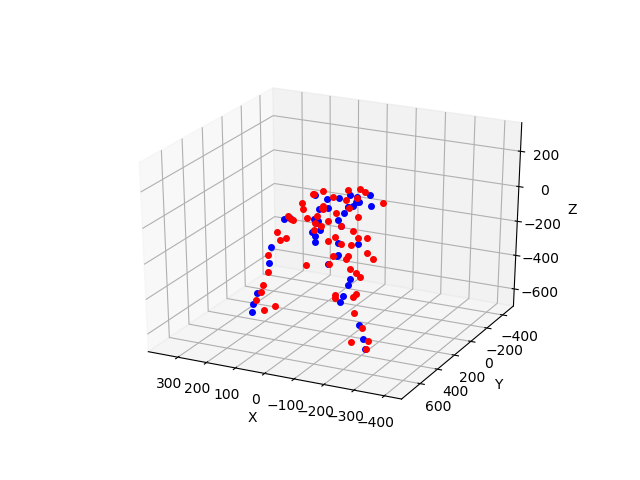

In [11]:
ani1 = plot_utils.AnimatePlot()
ani1.animated_plot(joints_local[:,:,:,3],nn.predict(joints_local),fps=60)

<IPython.core.display.Javascript object>


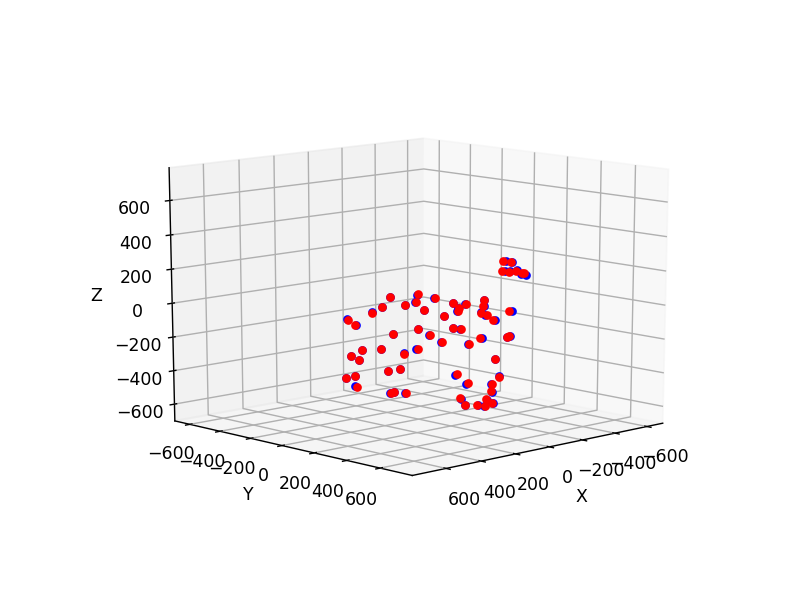

In [26]:
ani2 = plot_utils.AnimatePlot()
ani2.animated_plot(markers_local,nn.predict(joints_local))

<IPython.core.display.Javascript object>


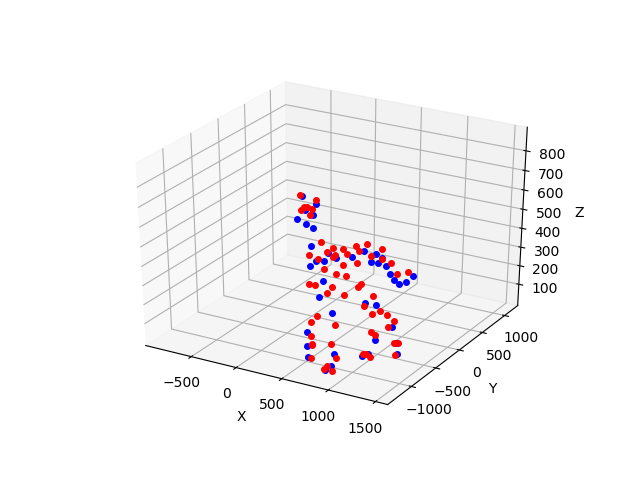

In [16]:
#Animate
ani3 = plot_utils.AnimatePlot()
ani3.animated_plot(joints_testseq[:,:,:,3],marker_preds_g, fps=60)

<IPython.core.display.Javascript object>


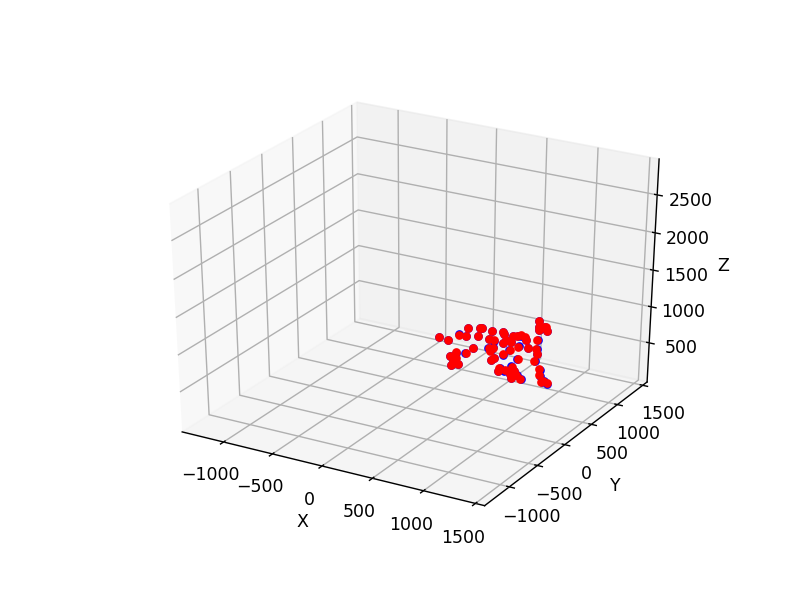

In [28]:
#Animate
ani4 = plot_utils.AnimatePlot()
ani4.animated_plot(markers_testseq,marker_preds_g)